In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Use this command if you didn't save your credentials:
service = QiskitRuntimeService(channel="ibm_quantum", token="63fe2dff151a1fa50f67b735e09f867d6a2b0380862c050ddac3bdb597586e4818b7a86afe0861d76d84be7f577561808c6a540f48dfb40f6406c056abf86e4c")

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit import Aer
from qiskit.opflow import X, Z, I, MatrixEvolution
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit import Parameter
from qiskit import transpile
from scipy import linalg
from scipy.special import binom
import matplotlib.pyplot as plt
import itertools as it
import copy
import stomp_functions as stf
from qiskit.quantum_info import random_clifford
import time
from qiskit.providers.fake_provider import FakeBelem, FakePerth
from qiskit_ibm_runtime import Estimator, Sampler,  Options
from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import HGate
from qiskit_aer.noise import NoiseModel

In [3]:
def create_H(N, g, j):
    z_ops, x_ops = stf.construct_op_lists(N)
    
    # Construct the Hamiltonian
    # Loop over sites to construct parts of H
    H_qis = 0
    for n in range(N-1):
        H_qis += -j * z_ops[n] @ z_ops[n+1]
        for m in range(N):
            H_qis += -j * g * x_ops[n]

    return H_qis

In [4]:
def re_sampler_circs(qr, cr, H, obs, numsteps, cliff):
    circ_list = []
    if obs is not None:
        obs_circ = QuantumCircuit([qr[1], qr[2]])
        obs_circ.append(Operator(obs), [qr[1], qr[2]])
        obs_gate = obs_circ.to_gate().control(1)
        
    for n in range(numsteps):
        # Set up circuit
        circ = QuantumCircuit(qr, cr)
        
        # Apply clifford to main circuits and Hadamard to ancilla
        circ.append(cliff.to_circuit(), [1, 2])
        circ.h(0)
        
        # Create Uf
        U_f = (-float(n * np.sqrt(dt / 2)) * H).exp_i().to_circuit().to_gate().control(1)
        circ.append(U_f, [0, 1, 2])
        
        # Apply observable if it exits
        if obs is not None:
            circ.append(obs_gate, [0, 1, 2])
            
        # Apply x to ancilla
        circ.x(0)
        
        # Create Ub
        U_b = (float(n * np.sqrt(dt / 2)) * H).exp_i().to_circuit().to_gate().control(1)
        circ.append(U_b, [0, 1, 2])
        
        # Apply final Hadamard to ancilla
        circ.h(0)
        
        # Apply measurement to ancilla
        circ.measure([0], [0])
        
        # Append to list
        circ_list.append(circ)
        
    return circ_list       
        

In [5]:
def im_sampler_circs(qr, cr, H, obs, numsteps, cliff):        
    circ_list = []
    if obs is not None:
        obs_circ = QuantumCircuit([qr[1], qr[2]])
        obs_circ.append(Operator(obs), [qr[1], qr[2]])
        obs_gate = obs_circ.to_gate().control(1)
        
    for n in range(numsteps):
        # Set up circuit
        circ = QuantumCircuit(qr, cr)
        
        # Apply clifford to main circuits and Hadamard to ancilla
        circ.append(cliff.to_circuit(), [1, 2])
        circ.h(0)
        circ.s(0)
        
        # Create Uf
        U_f = (-float(n * np.sqrt(dt / 2)) * H).exp_i().to_circuit().to_gate().control(1)
        circ.append(U_f, [0, 1, 2])
        
        # Apply observable if it exits
        if obs is not None:
            circ.append(obs_gate, [0, 1, 2])
            
        # Apply x to ancilla
        circ.x(0)
        
        # Create Ub
        U_b = (float(n * np.sqrt(dt / 2)) * H).exp_i().to_circuit().to_gate().control(1)
        circ.append(U_b, [0, 1, 2])
        
        # Apply final Hadamard to ancilla
        circ.h(0)
        
        # Apply measurement to ancilla
        circ.measure([0], [0])
        
        # Append to list
        circ_list.append(circ)
        
    return circ_list       

In [6]:
def get_p0s(results):
    p0s = []
    for _ in results:
        if '0' in _.keys():
            p0s.append(_['0'])
        else:
            p0s.append(0)
    
    return np.array(p0s)

In [7]:
def had_est_sampler(qr, cr, H, cliff, sampler_options, num_steps):
    backend = service.backend("ibmq_qasm_simulator")
    sampler = Sampler(backend=backend, options=sampler_options)
    
    # Real Z
    re_circ_list = re_sampler_circs(qr, cr, H, None, num_steps, cliff)
    job = sampler.run(re_circ_list)
    re_results = [_.binary_probabilities() for _ in job.result().quasi_dists]
    re_ovlp = 2 * get_p0s(re_results) - 1
    
    # Imag Z
    im_circ_list = im_sampler_circs(qr, cr, H, None, num_steps, cliff)
    job = sampler.run(im_circ_list)
    im_results = [_.binary_probabilities() for _ in job.result().quasi_dists]
    im_ovlp =  2 * get_p0s(im_results) - 1
    
    # Combine
    ovlps = re_ovlp + 1j * im_ovlp
    
    # Get pauli decomposition of H
    pauli = stf.pauli_string_decomp(H, 2)
    
    # Get circuits for each key
    re_H_circs = {}
    im_H_circs = {}
    for key in paulis:
        if abs(paulis[key]) != 0:
            re_H_circs[key] = re_sampler_circs(qr, cr, H, Pauli(key), num_steps, cliff)
            im_H_circs[key] = im_sampler_circs(qr, cr, H, Pauli(key), num_steps, cliff)
            
    # Process real part
    re_H_ovlp = 0
    for key in re_H_circs:
        job = sampler.run(re_H_circs[key])
        results = [_.binary_probabilities() for _ in job.result().quasi_dists]
        temp = 2 * get_p0s(results) - 1
        re_H_ovlp += paulis[key] * temp / np.sqrt(2 ** (2*N))
    
    # Process imaginary part
    im_H_ovlp = 0
    for key in im_H_circs:
        job = sampler.run(im_H_circs[key])
        results = [_.binary_probabilities() for _ in job.result().quasi_dists]
        temp = 2 * get_p0s(results) - 1
        im_H_ovlp += paulis[key] * temp / np.sqrt(2 ** (2*N))
        
    # Combine
    H_ovlps = re_H_ovlp + 1j * im_H_ovlp
    
    return ovlps, H_ovlps

In [8]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [9]:
# Define Hamiltonian parameters
N = 2
g = 2
j = 1

In [10]:
# Set up parameters for unitary
beta = 1
num_steps = 80
betas, dt = np.linspace(0, beta, num_steps, retstep=True)

In [11]:
# Create clifford gate we'll use
cliff = random_clifford(N, seed=5)

In [12]:
# Create Hamiltonian
z_ops, x_ops = stf.construct_op_lists(N)

H = create_H(N, g, j)
E, V = linalg.eigh(H.to_matrix())

## Classical

In [13]:
init_wf = cliff.to_matrix() @ np.array([1, 0, 0, 0])
class_ovlp, class_H_ovlp = stf.classical_calc(init_wf, H.to_matrix(), H.to_matrix(), num_steps, dt)

## Sampler

In [14]:
# Make a noise model
fake_backend = FakeBelem()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}

In [15]:
#backend = service.backend("ibmq_qasm_simulator")
backend = service.backend("ibm_brisbane")
sampler = Sampler(backend=backend, options=None)

In [16]:
# Set up circuit parameter
qr = QuantumRegister(3)
cr = ClassicalRegister(1)

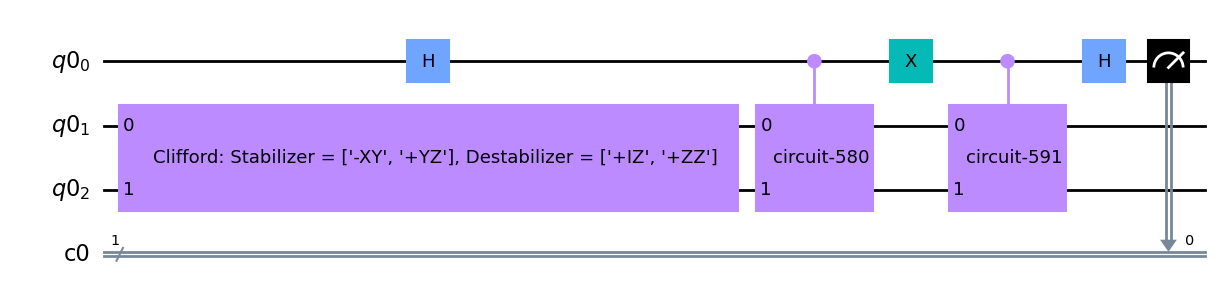

In [17]:
# Real part, no observable
re_circ_list = re_sampler_circs(qr, cr, H, None, num_steps, cliff)
re_circ_list[0].draw('mpl')

In [18]:
# Get real overlap
#job = sampler.run(re_circ_list)
#re_results = [_.binary_probabilities() for _ in job.result().quasi_dists]
#re_ovlp = 2 * get_p0s(re_results) - 1

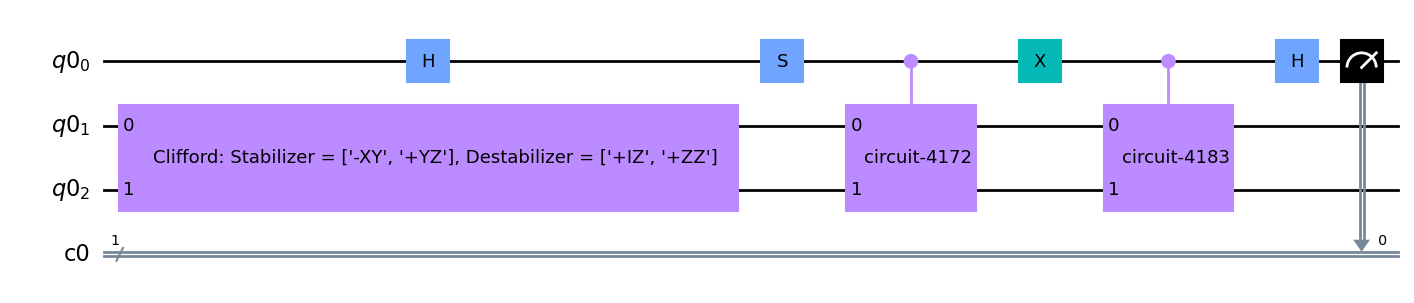

In [19]:
# Imaginary part, no observable
im_circ_list = im_sampler_circs(qr, cr, H, None, num_steps, cliff)
im_circ_list[0].draw('mpl')

In [20]:
# Get imaginary overlap
#job = sampler.run(im_circ_list)
#im_results = [_.binary_probabilities() for _ in job.result().quasi_dists]
#im_ovlp = 2 * get_p0s(im_results) - 1

In [21]:
#ovlps = re_ovlp + 1j * im_ovlp

In [22]:
# Pauli string decomposition of H
paulis = stf.pauli_string_decomp(H, 2)

In [23]:
# Real part, Hamiltonian
re_H_circs = {}
for key in paulis:
    if abs(paulis[key]) != 0:
        re_H_circs[key] = re_sampler_circs(qr, cr, H, Pauli(key), num_steps, cliff)

In [24]:
#re_H_circs['XI'][-1].draw('mpl')

In [25]:
#re_H_ovlp = 0
#for key in re_H_circs:
#    job = sampler.run(re_H_circs[key])
#    results = [_.binary_probabilities() for _ in job.result().quasi_dists]
#    temp = 2 * get_p0s(results) - 1
#    re_H_ovlp += paulis[key] * temp / np.sqrt(2 ** (2*N))

In [26]:
# Imaginary part, Hamiltonian
im_H_circs = {}
for key in paulis:
    if abs(paulis[key]) != 0:
        im_H_circs[key] = im_sampler_circs(qr, cr, H, Pauli(key), num_steps, cliff)

In [27]:
#im_H_ovlp = 0
#for key in im_H_circs:
#    job = sampler.run(im_H_circs[key])
#    results = [_.binary_probabilities() for _ in job.result().quasi_dists]
#    temp = 2 * get_p0s(results) - 1
#    im_H_ovlp += paulis[key] * temp / np.sqrt(2 ** (2*N))

In [28]:
#H_ovlp = re_H_ovlp + 1j * im_H_ovlp

## Comparison

In [29]:
# Create a larger list of circuits to try and reduce the number of calls to ibm
# then compare results to above
circ_list = re_circ_list + im_circ_list

In [30]:
for key in re_H_circs:
    circ_list += re_H_circs[key]
    circ_list += im_H_circs[key]

In [ ]:
job = sampler.run(circ_list)
results = [_.binary_probabilities() for _ in job.result().quasi_dists]
ovlp = 2 * get_p0s(results) - 1

In [ ]:
len(ovlp)

In [ ]:
re_H_circs.keys(), paulis.values()

In [ ]:
z = []
O = []
for i in range(num_steps):
    z.append(ovlp[i] + 1j*ovlp[i+num_steps])
    temp = 0
    for j, key in enumerate(re_H_circs):
        α = paulis[key]
        k = 2*(j + 1)
        temp += α * (ovlp[i + k * num_steps] + 1j*ovlp[i + (k+1) * num_steps]) / np.sqrt(2 ** (2*N))
    O.append(temp)
z = np.array(z)
O = np.array(O)

In [ ]:
plt.figure(1)
plt.plot(betas, class_ovlp.real, 'o-', label='Classical')
#plt.plot(betas, ovlps.real, 'x-', label='Sampler')
plt.plot(betas, z.real, 'x-', label='Sampler 2')
plt.xlabel("$\\beta$")
plt.ylabel("Real Ovlp")
plt.legend()

plt.figure(2)
plt.plot(betas, class_ovlp.imag, 'o-', label='Classical')
#plt.plot(betas, ovlps.imag, 'x-', label='Sampler')
plt.plot(betas, z.imag, 'x-', label='Sampler 2')
plt.xlabel("$\\beta$")
plt.ylabel("Imag Ovlp")
plt.legend()

In [ ]:
plt.figure(1)
plt.plot(betas, class_H_ovlp.real, 'o-', label='Classical')
#plt.plot(betas, H_ovlp.real, 'x-', label='Sampler')
plt.plot(betas, O.real, 'x-', label='Sampler')
plt.xlabel("$\\beta$")
plt.ylabel("Real <H>")
plt.legend()

plt.figure(2)
plt.plot(betas, class_H_ovlp.imag, 'o-', label='Classical')
#plt.plot(betas, H_ovlp.imag, 'x-', label='Sampler')
plt.plot(betas, O.imag, 'x-', label='Sampler')
plt.xlabel("$\\beta$")
plt.ylabel("Imag <H>")
plt.legend()

In [ ]:
# Do partition calculation with both
# first plot ground state
λ_0 = 1*E[0]
plt.plot(betas, E[0]*np.ones(len(betas)), '-.', color="#0072B2")
#plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, H_ovlp, num_steps,
#                                             λ_0, dt)[1][1:]-λ_0, '--', color="#0072B2",
#                label='Expt. U, $\\lambda = E_0$')
plt.plot(betas[2::2], stf.alt_partition_calc(z, O, num_steps,
                                             λ_0, dt)[1][1:]-λ_0, '-', color="#0072B2",
        label='$\\lambda = ' + str(λ_0) + "$")

# Now plot the first excited state
λ_1 = 1*E[2]
plt.plot(betas, E[2]*np.ones(len(betas)), '-.', color="#D55E00")
#plt.plot(betas[2::2], stf.alt_partition_calc(ovlps, H_ovlp, num_steps,
#                                             λ_1, dt)[1][1:]-λ_1, '--', color="#D55E00",
#                label='Expt. U, $\\lambda = E_1$')
plt.plot(betas[2::2], stf.alt_partition_calc(z, O, num_steps,
                                             λ_1, dt)[1][1:]-λ_1, '-', color="#D55E00",
        label='$\\lambda = ' + str(λ_1) + "$")

plt.xlabel("$\\beta$")
plt.ylabel("E")
plt.legend()